In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_circles, load_iris
from sklearn import preprocessing
dir_ = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
os.chdir(dir_)
# Local modules
import utils
import prior
import transformer
import main

# Settings
matplotlib.use("TkAgg")
warnings.filterwarnings("ignore")
%matplotlib inline


In [2]:
url = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/faithful.csv"
faithful_np = pd.read_csv(url, index_col=0).to_numpy()

In [3]:
print(f"Using device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
device = torch.device("cuda")
d_model, nhead, nhid, nlayers = 256, 4, 512, 4
in_features = 2
num_outputs = 10
model = transformer.Transformer(d_model, nhead, nhid, nlayers,in_features=in_features, buckets_size=num_outputs).to(device)
print(f"total params:{sum(p.numel() for p in model.parameters())}")
criterion = nn.CrossEntropyLoss()
model.criterion = criterion


checkpoint = torch.load("models/models_original/pfn_easy_2D.pt", weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval() 
print("")

Using device: Quadro P1000
total params:2115850



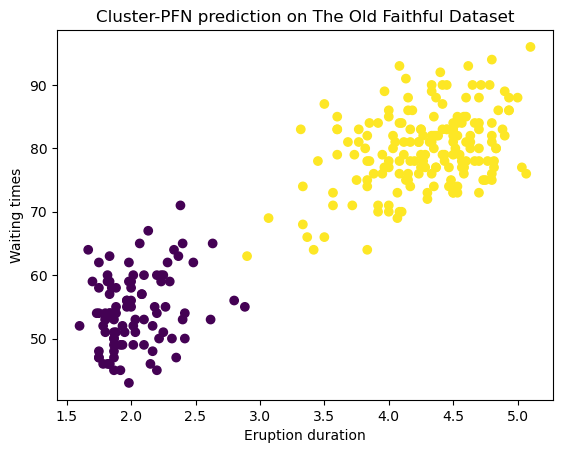

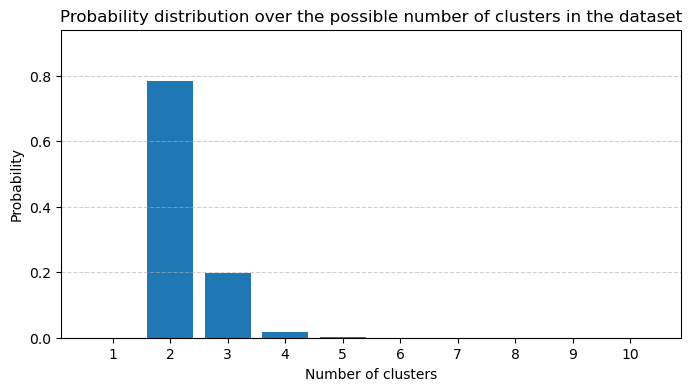

In [4]:
faithful_standard = preprocessing.MinMaxScaler().fit_transform(faithful_np)
faithful_tensor = torch.tensor(faithful_standard, dtype=torch.float32).to(device)
faithful_tensor = faithful_tensor.unsqueeze(1)
logits,cluster_output = model(faithful_tensor, torch.full((1,1), 0, dtype=torch.long, device=device))
logits = logits.squeeze(1)
cluster_output = cluster_output.cpu()
predictions = torch.argmax(logits, dim=1)
predictions = predictions.cpu()

plt.scatter(faithful_np[:, 0] , faithful_np[:, 1], c=predictions)
plt.title("Cluster-PFN prediction on The Old Faithful Dataset")
plt.xlabel("Eruption duration")
plt.ylabel("Waiting times")
plt.show()


probs_tensor = F.softmax(cluster_output, dim=-1)  # still shape [1, 1, 10]
probs = probs_tensor.squeeze().detach().numpy()
bins = np.arange(1, 11)

#Plot
plt.figure(figsize=(8, 4))
plt.bar(bins, probs, tick_label=bins)
plt.xlabel("Number of clusters")
plt.ylabel("Probability")
plt.title("Probability distribution over the possible number of clusters in the dataset")
plt.ylim(0, max(probs) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig("old_faitful_cluster_prediction.png")
plt.show()